## 1. Carga de datos y analisis individual de Datos

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, make_scorer

In [42]:
contract = pd.read_csv('final_provider/contract.csv')
personal = pd.read_csv('final_provider/personal.csv')
internet = pd.read_csv('final_provider/internet.csv')
phone = pd.read_csv('final_provider/phone.csv')

In [43]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [44]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [45]:
contract.duplicated().sum()

np.int64(0)

In [46]:
contract.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Tenemos 7043 filas, sin datos ausentes ni duplicados. Podemos ver 8 columnas en las cuales se encuentran el ID del cliente, la fecha cuando empezo el uso del servicio, la fecha en la que cancela el servicio, el tipo de servicio anual o mensual, si recibe o no recibo o factura electronico, el metodo de pago, cuanto cuesta la recaraga mensual, y el costo total del servicio.

La fecha de inicio de contrato no la concidero importanto para saber si un usuario va a cancelar o no el servicio, podria decirnos cual fue el mes o el año en el que mas usuarios contrataron un servicio con la compañia y poder hacer un proceso de marketing para dichos meses y que la gente se sienta atraida por promociones he ingrese al servicio.

Los datos objetivo son la fecha de cancelacion de la columna "EndDate", pienso que la informacion de la fecha de cancelacion solo da informacion de cuando la gente cancelo, pero es irrelevante ya que lo que hace que el cliente cancele no es ni su fecha de inicio ni el dia de cancelacion sino el servicio, por lo que el dato de fecha que aparece puede ser remplazado por "Yes" y asi facilitar procesos mas adelante para la creacion del modelo.

El tipo de servicio mensual o anual es un dato interesante ya que en los primeros datos vemos que de los 5 usuarios que se pueden ver tres es de pago mensual y ademas los tres cancelaron el servicio, por lo tanto con un analisis mas profundo veremos la importancia de esta dato para el modelo.

El metodo de pago puede ser otra de las causas de cancelacion del servicio, por lo general si el proceso es engorrozo la gente prefiere no tener que realizarlo y algunos optarian por cancelar el servicio buscando mas faciles y mejores metodos de pago.

El precio mensual o anual es una concideracion al pensar en cancelar un servicio ya que siempre se busca economizar pero que todos los servicios vengan incluidos.

Los datos a los que se le haria cambios serian los de la columna "EndDate" y los de la columna "TotalCharges" ya que estan en string "object" y los pasaria a "float". Los demas estan bien

In [47]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [48]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [49]:
personal.duplicated().sum()

np.int64(0)

In [50]:
personal.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

En el dataframe "personal" no tenemos datos ausentes o duplicados y tenemos la mismoa cantidad de datos que en el primer dataframe. En cuanto a la informacion que tiene, la columna "gender" puede presentar inportancia en el modelo ya que puede analizar si siendo mujer u hombre podria tener mas posibilidades de cancelar el servicio, lo mismo podria pasar la columna "SeniorCitizen" se podria averiguar si la gente joven o mayor es la que cancela mas el servicio. Con la columna "Partner" se veria si las personas que tienen pareja o estan solteras cancelan mas el servicio. Y finalmente en la columna "Dependents" permitiria ver si una persona de la que dependen familiares cancelaria el serivicio que una persona sin familiares o personas que dependan de él.

Estos datos no se modificaran hasta el proceso con el modelo.

In [51]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [52]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [53]:
internet.duplicated().sum()

np.int64(0)

In [54]:
internet.isna().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

A partir de este dataframe las cosas cambian. No tenemos la misma cantidad de filas que los dataframes anteriores, eso podria deberse a que no todos los usuarios tienen los servicios de internet. Por lo cual si se realiza una union de dataframes es necesario completar los datos ausentes que se generen. En cuanto a la importancia de los datos brindados por las columnas, a mi parecer cada una de ellas presenta informacion importante ya que dependiendo de que servicio tengan los usuarios y si son de su agrado o no esto influye en la posibilidad de cancelar o no el serivicio.

In [55]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [56]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [57]:
phone.duplicated().sum()

np.int64(0)

In [58]:
phone.isna().sum()

customerID       0
MultipleLines    0
dtype: int64

Este dataframe presenta casi la misma situacion del anterior, a pesar de no tener datos ausentes ni duplicados en él, no tiene la misma cantidad de datos que los dos primeros datasets, debido a que no todos los clientes tienen el servicio de Multiples lineas que aca muestran con la columna "MultipleLines", un dato que tambien cuenta con importancia para el modelo ya que dependiendo si el usuario tiene este servicio y ademas le a sido util y beneficioso los usuarios no cancelarian el servicio.

## 2. Fusion de dataframes y mejora de datos

Fucionamos los dataframes preservando los datos base de "contract", arreglaremos algunos datos, completaremos los ahora datos ausentes que aparecen de la fusion y veremos la relacion que tienen con los datos objetivo de la columna "EndDate".

In [59]:
df = contract.merge(personal, on='customerID', how='left')\
                  .merge(internet, on='customerID', how='left')\
                  .merge(phone, on='customerID', how='left')

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Despues de fusionar los dataframe vamos a completar los datos ausentes en el dataframe final, al ser datos cualitativos y sabiendo que los datos ausentes son porque no todos los usuarios tienen todos los servicios dados por la compañia, a los faltantes le pondremos "No_service" y "No_phone" dependiendo del servicio.

In [61]:
df['InternetService'] = df['InternetService'].fillna('No_service')

df['MultipleLines'] = df['MultipleLines'].fillna('No_phone')

In [62]:
# Para características de internet, "No" cuando no hay servicio
internet_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                 'TechSupport', 'StreamingTV', 'StreamingMovies']
df[internet_cols] = df[internet_cols].fillna('No_service')

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


Ahora con datos completos vamos a crear una columna objetivo nueva que se llamara "Churn", en la que el "No" en la columna "EndDate" sea "0" o clientes activos y los que ya cancelaron el servicio sean "1", ademas tenemos que hacer unos cambios con respecto a las columnas con datos de fechas y con la columna "TotalCharges" que deberia ser numerica y no de texto. Y tambien crearemos una columna nueva con el dato de la permanencia de los clientes y se llamara "Tenure".

In [64]:
df['Churn'] = np.where(df['EndDate'] == 'No', 0, 1)

In [65]:
# Convertir fechas y calcular tenure
df['BeginDate'] = pd.to_datetime(df['BeginDate'])
df['EndDate_clean'] = pd.to_datetime(df['EndDate'].replace('No', pd.NaT), errors='coerce')

In [66]:
reference_date = df['BeginDate'].max() + pd.DateOffset(months=1)
df['Tenure'] = np.where(
    df['Churn'] == 0,
    (reference_date - df['BeginDate']).dt.days,
    (df['EndDate_clean'] - df['BeginDate']).dt.days
)

Voy a averiguar si no habia problema en convertir la columna "TotalCharges" a valores numericos

np.array_equal(df['TotalCharges'], df['TotalCharges'].astype('float'))

ALcorrer la linea de codigo de convertir la columna "TotalCharges" sale el siguiente error:

ValueError Traceback (most recent call last) Cell In[28], line 1 ----> 1 np.array_equal(df['TotalCharges'], df['TotalCharges'].astype('float'))

File /.venv/lib/python3.9/site-packages/pandas/core/generic.py:5877, in NDFrame.astype(self, dtype, copy, errors) 5870 results = [ 5871 self.iloc[:, i].astype(dtype, copy=copy) 5872 for i in range(len(self.columns)) 5873 ] 5875 else: 5876 # else, only a single dtype is given -> 5877 new_data = self._mgr.astype(dtype=dtype, copy=copy, errors=errors) 5878 return self._constructor(new_data).finalize(self, method="astype") 5880 # GH 33113: handle empty frame or series

File /.venv/lib/python3.9/site-packages/pandas/core/internals/managers.py:631, in BlockManager.astype(self, dtype, copy, errors) 628 def astype( 629 self, dtype, copy: bool = False, errors: str = "raise" 630 ) -> "BlockManager": --> 631 return self.apply("astype", dtype=dtype, copy=copy, errors=errors)

File /.venv/lib/python3.9/site-packages/pandas/core/internals/managers.py:427, in BlockManager.apply(self, f, align_keys, ignore_failures, **kwargs) 425 applied = b.apply(f, **kwargs) 426 else: --> 427 applied = getattr(b, f)(**kwargs) 428 except (TypeError, NotImplementedError): 429 if not ignore_failures:

File /.venv/lib/python3.9/site-packages/pandas/core/internals/blocks.py:673, in Block.astype(self, dtype, copy, errors) 671 vals1d = values.ravel() 672 try: --> 673 values = astype_nansafe(vals1d, dtype, copy=True) 674 except (ValueError, TypeError): 675 # e.g. astype_nansafe can fail on object-dtype of strings 676 # trying to convert to float 677 if errors == "raise":

File /.venv/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1097, in astype_nansafe(arr, dtype, copy, skipna) 1093 raise ValueError(msg) 1095 if copy or is_object_dtype(arr) or is_object_dtype(dtype): 1096 # Explicit copy, or required since NumPy can't view from / to object. -> 1097 return arr.astype(dtype, copy=True) 1099 return arr.view(dtype)

ValueError: could not convert string to float: ''


Al parecer hay un valor " " en espacio voy a revisar con value_counts

In [67]:
df['TotalCharges'].value_counts(dropna=False)

TotalCharges
20.2      11
          11
19.75      9
19.65      8
19.9       8
          ..
1990.5     1
7362.9     1
346.45     1
306.6      1
108.15     1
Name: count, Length: 6531, dtype: int64

Efectivamente hay 11 valores como espacio y no permiten convertir los datos a tipo numerico, voy a hallar los datos y ver cual es el problema para poder completar dichos valores sin tener problemas para el modelo.

In [68]:
# Filtrar registros con TotalCharges vacío o inválido
missing_charges = df[df['TotalCharges'].str.strip().isin(['', ' '])].copy()

print(f"Total registros con TotalCharges vacío: {len(missing_charges)}")
print(missing_charges[['customerID', 'BeginDate', 'EndDate', 'MonthlyCharges', 'Type', 'Tenure']])

Total registros con TotalCharges vacío: 11
      customerID  BeginDate EndDate  MonthlyCharges      Type  Tenure
488   4472-LVYGI 2020-02-01      No           52.55  Two year    29.0
753   3115-CZMZD 2020-02-01      No           20.25  Two year    29.0
936   5709-LVOEQ 2020-02-01      No           80.85  Two year    29.0
1082  4367-NUYAO 2020-02-01      No           25.75  Two year    29.0
1340  1371-DWPAZ 2020-02-01      No           56.05  Two year    29.0
3331  7644-OMVMY 2020-02-01      No           19.85  Two year    29.0
3826  3213-VVOLG 2020-02-01      No           25.35  Two year    29.0
4380  2520-SGTTA 2020-02-01      No           20.00  Two year    29.0
5218  2923-ARZLG 2020-02-01      No           19.70  One year    29.0
6670  4075-WKNIU 2020-02-01      No           73.35  Two year    29.0
6754  2775-SEFEE 2020-02-01      No           61.90  Two year    29.0


Podemos ver que el inconveniente sucede en un mismo dia, ademas todos los clientes estan activos, y casi todos son clientes que tienen un servicio pagado por dos años y tienen la misma permanencia en el serivicio. Puede ser que halla habido un error en el procedimiento de captura de datos en esa fecha lo que causo este error por lo que vamos a proceder con completar dichos datos de la forma mas optima. Para ello verificaremos que no halla un cambio en las estadisticas de la columna "TotalCharges" y calcularemos los datos en blanco con su proporcion al tiempo de permanencia en el servicio.

In [69]:
print("\nEstadísticas de TotalCharges antes de corrección:")
print(df['TotalCharges'].describe())


Estadísticas de TotalCharges antes de corrección:
count     7043
unique    6531
top       20.2
freq        11
Name: TotalCharges, dtype: object


In [70]:
# Calcular TotalCharges proporcional al tiempo
df.loc[df['TotalCharges'].str.strip() == '', 'TotalCharges'] = (
    df['MonthlyCharges'] * (df['Tenure'] / 30)  # Aproximación mensual
)

In [71]:
# Verificar los registros corregidos
corrected = df.iloc[missing_charges.index][['customerID', 'MonthlyCharges', 'Tenure', 'TotalCharges']]
print(corrected)

# Verificar estadísticas descriptivas
print("\nEstadísticas de TotalCharges después de corrección:")
print(df['TotalCharges'].describe())

      customerID  MonthlyCharges  Tenure TotalCharges
488   4472-LVYGI           52.55    29.0    50.798333
753   3115-CZMZD           20.25    29.0       19.575
936   5709-LVOEQ           80.85    29.0       78.155
1082  4367-NUYAO           25.75    29.0    24.891667
1340  1371-DWPAZ           56.05    29.0    54.181667
3331  7644-OMVMY           19.85    29.0    19.188333
3826  3213-VVOLG           25.35    29.0       24.505
4380  2520-SGTTA           20.00    29.0    19.333333
5218  2923-ARZLG           19.70    29.0    19.043333
6670  4075-WKNIU           73.35    29.0       70.905
6754  2775-SEFEE           61.90    29.0    59.836667

Estadísticas de TotalCharges después de corrección:
count     7043
unique    6541
top       20.2
freq        11
Name: TotalCharges, dtype: object


Podemos ver que las estadisticas de antes y despues de completar los datos tuvieron solo cambios en los valores unicos al agregrar los datos nuevos, por lo tanto el procedimiento no causara ningun inconveniente para la creacion del modelo

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

Ahora si transformamos los valores de "TotalCharges" a valores numericos tipo decimal "float"

In [73]:
df['TotalCharges'] = df['TotalCharges'].astype('float')

In [74]:
print(df['TotalCharges'].dtype)  # Debería mostrar float64
print(df['TotalCharges'].isna().sum())  # Debería ser 0

float64
0


## 3. Análisis Exploratorio de Datos (EDA)

Ahora vamos a analisar los datos empezando con la proporcion de datos de personas que son clientes activos y clientes que han terminado el contrato de servicios con la compañia.

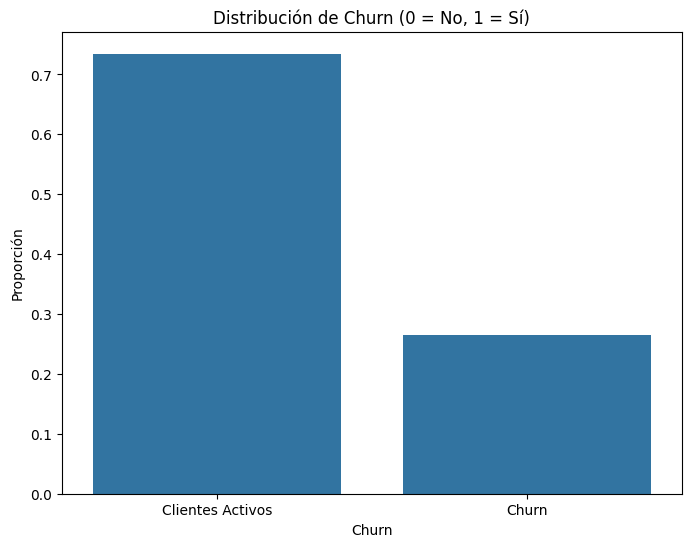

Porcentaje de Churn: 26.54%


In [75]:
# Distribución de Churn
plt.figure(figsize=(8, 6))
churn_dist = df['Churn'].value_counts(normalize=True)
sns.barplot(x=churn_dist.index, y=churn_dist.values)
plt.title('Distribución de Churn (0 = No, 1 = Sí)')
plt.ylabel('Proporción')
plt.xticks([0, 1], ['Clientes Activos', 'Churn'])
plt.show()

print(f"Porcentaje de Churn: {churn_dist[1]*100:.2f}%")

Podemos ver que analizando la proporcion de datos de clientes activos y de abandonos que seran los datos objetivos en el modelo estan desproporcional siendo solo el 26.54% personas que han abandonado el servicio, eso produciria un desbalanceo en el modelo y no seria confiable, eso se solucionara en el proceso de balanaceo de datos.

## 3.2 Analisis de variables numericas con respecto a variable objetivo

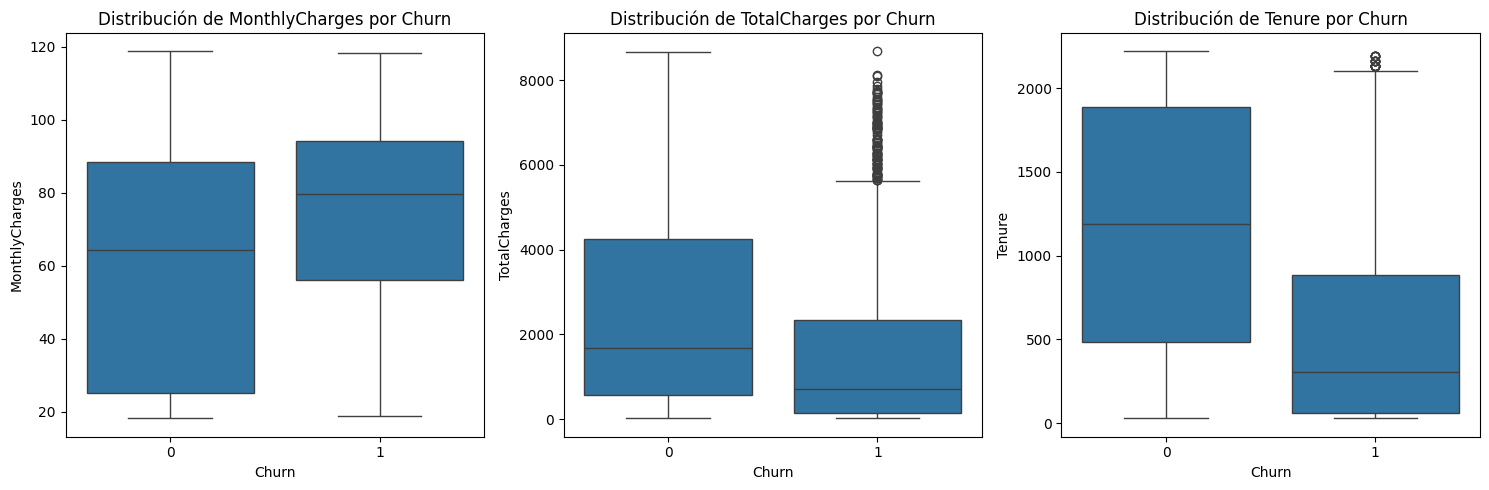

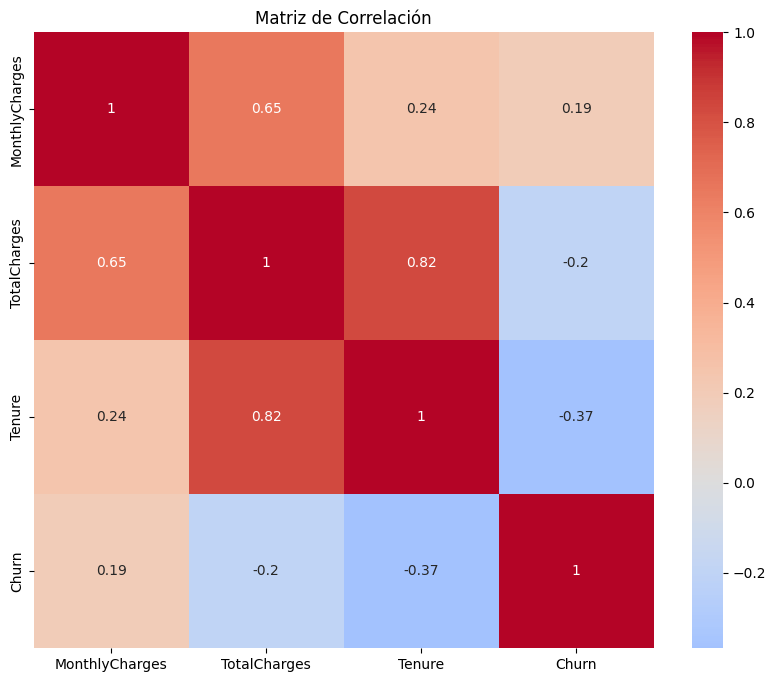

In [76]:
# Seleccionar variables numéricas
numeric_cols = ['MonthlyCharges', 'TotalCharges', 'Tenure']

# Distribución y relación con Churn
plt.figure(figsize=(15, 5))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f'Distribución de {col} por Churn')
plt.tight_layout()
plt.show()

# Matriz de correlación
plt.figure(figsize=(10, 8))
corr_matrix = df[numeric_cols + ['Churn']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')
plt.show()

En las graficas de caja se pueden ver la distribucion de los datos de los clientes que siguen activos y los que han abandonado el servicio, con respecto a los cargos mensuales, cargos totales y el tiempo de permanencia.

En la primera grafica de caja se ve que los clientes que abandonan el servicio tienden a tener cargos mensuales más altos en comparación con aquellos que permanecen en la empresa. Esto sugiere que los precios pueden ser un factor clave en la deserción.

En la segunda grafica de cajas se ve que los clientes que abandonan el servicio tienen unos cargos totales significativamente menores en comparación con los clientes que permanecen. Eso puede ser porque los clientes que abandonan son clientes han acumulado menos cargos porque puede que sean clientes relativamente nuevos

En la tercera grafica se muestra que los clientes que abandonan el servicio tienden a durar poco en la compañia, lo que ratifica el grafico anterior, esto es porque posiblemente encuentran un servicio mas economico o mejor en otra empresa.

En cuanto a la matriz de correlacion podemos ver:

que la relacion entre tiempo de permanencia (tenure) y los abandonos (churn) tienen correlacion negativa que confirma que los clientes con mas tiempo de permanencia son menos propensos a abandonar el servicio.
Lo mismo pasa con la correlacion entre permanencia y cargos totales lo que quiere decir que los que han invertido mas en la empresa son los que tienen menos probabilidad de abandonarla
Con respecto a la correlacion entre cargos mensuales y permanencia podemos ver que es positiva lo que nos dice que los clientes que pagan mas mensualmente son los que tienden a abandonar el servicio
Estos datos van a ser de mucha importancia para el modelo especialmente la permanecia ya que tiene una alta correlacion con el abandono de clientes.

## 3.3 Análisis de Variables Categóricas

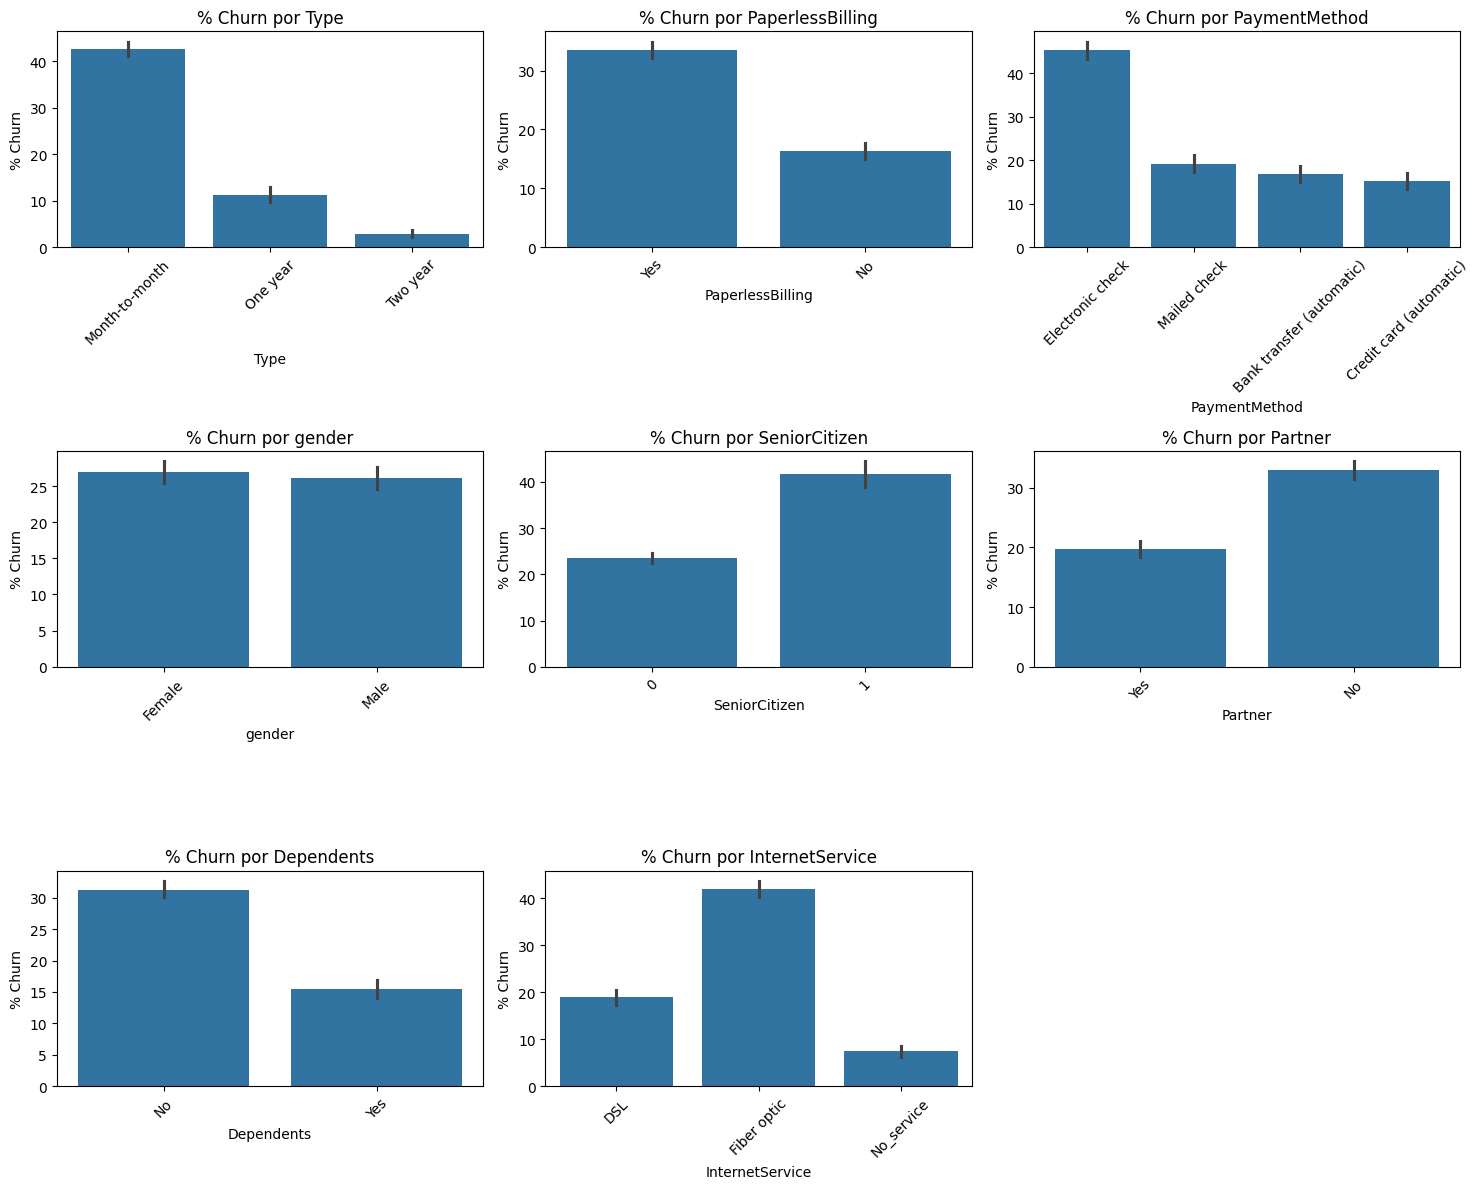

In [77]:
# Lista de variables categóricas importantes
cat_cols = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 
            'SeniorCitizen', 'Partner', 'Dependents', 'InternetService']

# Visualización de relación con Churn
plt.figure(figsize=(15, 12))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(3, 3, i)
    sns.barplot(x=col, y='Churn', data=df, estimator=lambda x: sum(x)/len(x)*100)
    plt.title(f'% Churn por {col}')
    plt.ylabel('% Churn')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

En las graficas podemos ver los porcentajes de abandono con respecto a las variables categoricas que hay en el dataset fusionado, y podemos ver las siguientes caracteristicas:

Hay un mayor porcentaje de abandonos cuando los clientes mantienen un servicio mes a mes y no cuando es anual o de dos años.

Hay mayor porcentajes de abandono cuando las personas reciben factura electronica.

Hay mayor abandono cuando el pago es electronico.

Al parecer el ser hombre o mujer no tiene casi relevancia en abandonar el servicio.

Las personas mayores son mas propensas a abandonar los servicios.

Las personas sin pareja tienden a abandonar con mayor porcentaje los servicios de la empresa.

Si eres una persona que no tiene personas que dependen de ti como familiares tienes mayor probabilidad de abandonar el servicio.

Si tu servicio de internet es mediante fibra optica tienes mas posibilidades de dejar de tomar los servicios de la compañia.

## 3.4 Análisis de Servicios Adicionales

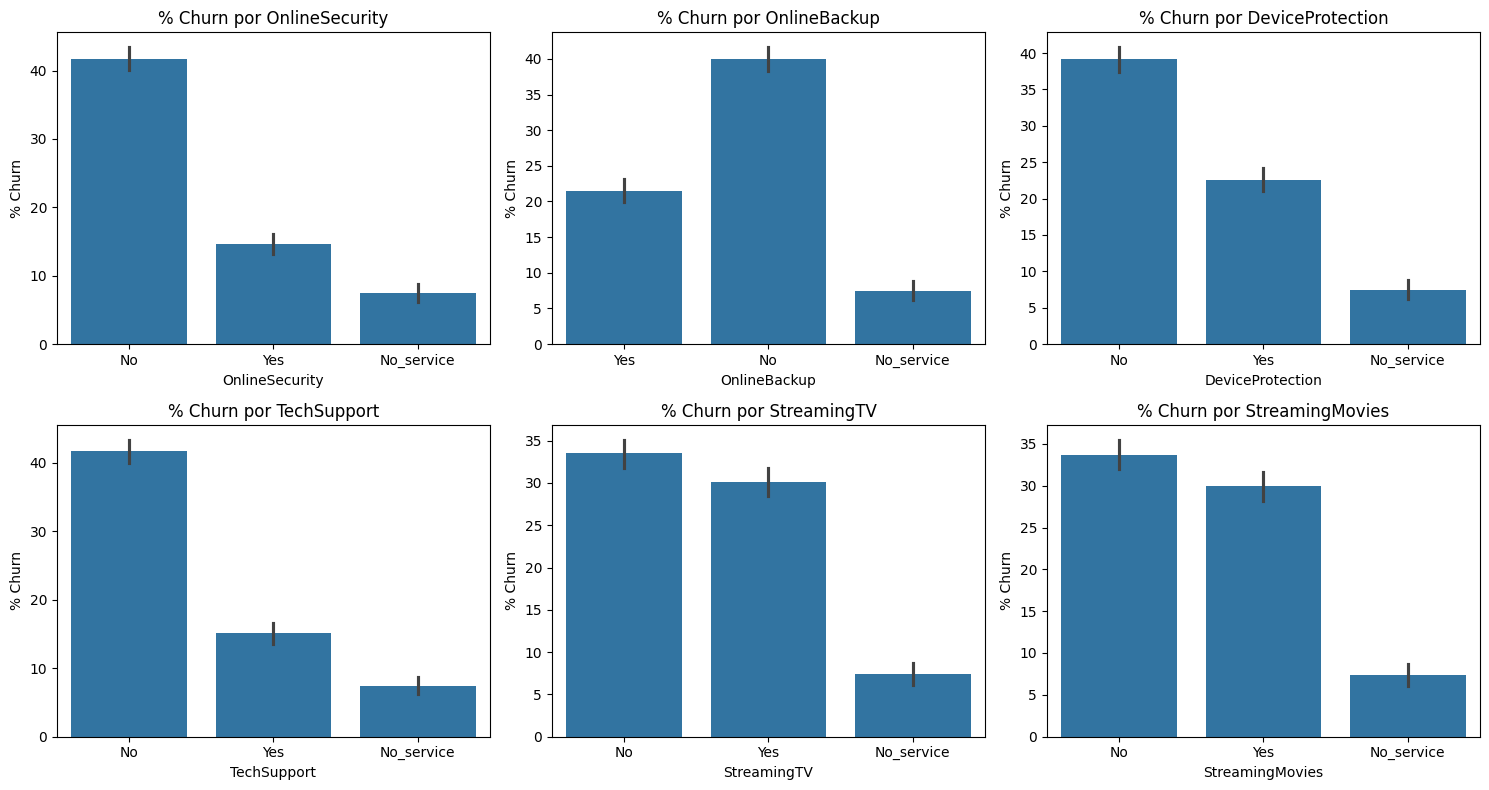

In [78]:
# Servicios adicionales
services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
            'TechSupport', 'StreamingTV', 'StreamingMovies']

# Visualización
plt.figure(figsize=(15, 8))
for i, col in enumerate(services, 1):
    plt.subplot(2, 3, i)
    sns.barplot(x=col, y='Churn', data=df, estimator=lambda x: sum(x)/len(x)*100)
    plt.title(f'% Churn por {col}')
    plt.ylabel('% Churn')
plt.tight_layout()
plt.show()

Con respecto a los servicios adicionales que brinda la compañia podemos ver lo siguiente:

Las personas que no tienen servicio de seguridad online tienen mayor probabilidad de abandonar los servicios de la empresa.
Lo mismo pasa para las personas que no tienen el servicio de Online Backup para salvar sus datos en linea, que no tienen proteccion para sus dispositivos, o soporte tecnico, o servicio de television o Peliculas Streaming. Por lo tanto estos servicios adicionales brindan informacion importante con respecto a que los usuarios sigan junto a la compañia o la dejen a un lado por posiblemente otra compañia que les brinde estos servicios de forma mas economica o con un mejor trato al cliente.

## Plan aproximado

1. para terminar con el mejoramiento de datos identificaria valores atipicos en los datos numericos y los quitaria para trabajar con datos mas limpios y que no afecten al modelo.

2. Dependiendo del modelo realizaria un proceso de codificado y estandarizado de datos.

3. Luego haria un balanceado de datos por el problema de balance que hay en los datos de abandono y permanencia.

4. Dependiendo de los modelos seleccionados para entrenarlos hallaria los mejores parametros para que den el mejor valor en la metrica de evaluacion

5. Entrenaria los modelos y seleccionaria al mejor para validacion y entrega final.

## 4. Arreglo de datos para el modelo

Ahora que hemos analizado los datos vamos a dejar las columnas necesarias para el entrenamiento del modelo. Por lo tanto la columna "EndDate_clean", la columna "customerID" y la columna "EndDate" seran eliminadas por las siguientes razones:

"EndDate_clean" fue creada para hallar los datos de permanencia "Tenure" y ademas presenta datos ausentes de los clientes que aun no han cancelado el servicio. Por lo que ya no es necesaria.

"customeID" es un dato irrelevante para el modelo.

"EndDate" es una columna con datos mixtos tiene fechas de cancelacion y "No" para las personas que no han cancelado, ademas los datos objetivo se cambiaron para la columna "Churn".

Y "BeginDate" a sido usada para la creacion de "Tenure" por lo tanto la informacion importante que nos podria brindar ya esta en esa nueva columna.

In [79]:
# Eliminar columnas redundantes
df = df.drop(['EndDate_clean', 'EndDate','customerID','BeginDate'], axis=1)

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   gender            7043 non-null   object 
 6   SeniorCitizen     7043 non-null   int64  
 7   Partner           7043 non-null   object 
 8   Dependents        7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  MultipleLines     7043 non-null   object 


In [81]:
df.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Churn,Tenure
0,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No_phone,0,60.0
1,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1065.0
2,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1,61.0
3,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No_phone,0,1400.0
4,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1,61.0


## 4.1 Codificacion de datos segun Modelos seleccionados para entrenar

Los modelos seleccionados para este proyecto seran RandomForest y XGBoost, por lo tanto se realizara el siguient procedimiento para que los modelos acepten los datos.

Se realizara una codificacion "mixta" ya que si aplicamos codificacion ONE-HOT a la columna 'Type' podria no brindar una informacion correcta al tener un orden natural por lo que se le hara una codificacion Ordinal medinate pandas, no por el metodo OrdinalEncode.

Para los demas datos que no tienen un orden natural usare el metodo OrdinalEncode de sklearn

In [82]:
df['Type'].value_counts(dropna=False)

Type
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

In [83]:
# Columna para OrdinalEncoder (con orden lógico)
type_dict = {'Month-to-month':0, 'One year':1, 'Two year':2}
df['Type'] = df['Type'].map(type_dict)

In [84]:
df['Type'].value_counts(dropna=False)

Type
0    3875
2    1695
1    1473
Name: count, dtype: int64

In [85]:
var_categorical = ['PaperlessBilling','PaymentMethod','gender','Partner','Dependents','InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
encoder = OrdinalEncoder()
encoder.fit(df[var_categorical])

OrdinalEncoder()

In [86]:
df[var_categorical] = encoder.transform(df[var_categorical])

In [87]:
df.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Churn,Tenure
0,0,1.0,2.0,29.85,29.85,0.0,0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0,60.0
1,1,0.0,3.0,56.95,1889.50,1.0,0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0,1065.0
2,0,1.0,3.0,53.85,108.15,1.0,0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1,61.0
3,1,0.0,0.0,42.30,1840.75,1.0,0,0.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,1.0,0,1400.0
4,0,1.0,2.0,70.70,151.65,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,61.0


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   int64  
 1   PaperlessBilling  7043 non-null   float64
 2   PaymentMethod     7043 non-null   float64
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   gender            7043 non-null   float64
 6   SeniorCitizen     7043 non-null   int64  
 7   Partner           7043 non-null   float64
 8   Dependents        7043 non-null   float64
 9   InternetService   7043 non-null   float64
 10  OnlineSecurity    7043 non-null   float64
 11  OnlineBackup      7043 non-null   float64
 12  DeviceProtection  7043 non-null   float64
 13  TechSupport       7043 non-null   float64
 14  StreamingTV       7043 non-null   float64
 15  StreamingMovies   7043 non-null   float64
 16  MultipleLines     7043 non-null   float64


## 5. Creacion de Modelos

Seleccionamos dos tipos de modelos que ya he trabajado en proyectos anteriores. Random Forest y LightGBM. Ambos trabajan muy bien con los datos procesados mediante OrdinalEncode por lo que no hay que hacer escalado de caracteristicas. Para el procedimiento hallare primero los mejores hiperparametros para cada modelo y luego pasare a hacer la prueba con dichos hiperparametros para hallar el valor de AUC-ROC mas alto posible

## 5.1 Random Forest

In [89]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [90]:
rf = RandomForestClassifier(random_state=42)


params_rf = {
    'max_depth': [5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 200]
}

grid_rf = GridSearchCV(rf, params_rf, scoring='roc_auc', cv=5)
grid_rf.fit(X_train, y_train)
print(f"Mejores parámetros RF: {grid_rf.best_params_}")

Mejores parámetros RF: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 100}


In [91]:
rf = RandomForestClassifier(
    class_weight='balanced',  # Manejo del desbalanceo
    n_estimators=100,
    min_samples_split= 2,
    max_depth=9,
    random_state=42
)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=9, random_state=42)

In [92]:
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]
print(f"RF - AUC-ROC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print(f"RF - Exactitud: {accuracy_score(y_test, rf.predict(X_test)):.4f}")

RF - AUC-ROC: 0.8966
RF - Exactitud: 0.8155


Con los mejores hiperparametros para el modelo Random Forest se ha conseguido un valor de AUC-ROC de 0.8966 un valor bastante alto que muestra que el modelo tiene una buena capacidad de distinguir entre los usuarios que van a abandonar el servicio y los que no. 

La exactitud confirma este datos ya que el 81% de las veces el modelo acierta al predecir que un usuario va a abandonar el servicio.

## 5.2 Modelo LightGBM

In [93]:
lgbm = lgb.LGBMClassifier(random_state=42)

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "class_weight": [None, "balanced"]
}

scoring = {"AUC": make_scorer(roc_auc_score, needs_proba=True), "Accuracy": "accuracy"}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configurar Grid Search
grid_search = GridSearchCV(
    lgbm, param_grid, scoring=scoring, refit="AUC", cv=cv, n_jobs=-1
)

# Ejecutar búsqueda
grid_search.fit(X, y)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor AUC-ROC:", grid_search.best_score_)

[LightGBM] [Info] Number of positive: 1869, number of negative: 5174
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 730
[LightGBM] [Info] Number of data points in the train set: 7043, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265370 -> initscore=-1.018243
[LightGBM] [Info] Start training from score -1.018243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

c:\Users\sergi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [94]:
lgb_model = lgb.LGBMClassifier(
 class_weight = 'balanced',
 n_estimators=100,
 learning_rate=0.1,
 max_depth=3,
 random_state=42
 )

In [95]:
lgbm.fit(X_train, y_train)
y_pred_train = lgbm.predict_proba(X_train)[:,1]
print(f"AUC-ROC con datos de entrenamiento: {roc_auc_score(y_train, y_pred_train):.4f}")
print(f"RF - Exactitud: {accuracy_score(y_train, rf.predict(X_train)):.4f}")

# Evaluación
y_pred_proba = lgbm.predict_proba(X_test)[:, 1]
print(f"AUC-ROC con datos de prueba: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"RF - Exactitud: {accuracy_score(y_test, rf.predict(X_test)):.4f}")

[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 721
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265531 -> initscore=-1.017418
[LightGBM] [Info] Start training from score -1.017418
AUC-ROC con datos de entrenamiento: 0.9985
RF - Exactitud: 0.8630
AUC-ROC con datos de prueba: 0.9868
RF - Exactitud: 0.8155


Con los mejores hiperparametros del modelo LightGBM se ha conseguido un casi perfecto modelo de prediccion de abandono con un valor de AUC-ROC 0.9868. Se podria considerar sospechozo ya que un valor tan alto en un proyecto de prediccion de abandono no es muy comun.

Para averiguar si el modelo estaba sobre entrenado halle los valores de AUC-ROC tanto con datos de entrenamiento y de prueba lo que no diria que el modelo se comporta muy parecido entre ambos grupos de datos demostrando que el modelo no esta sobre entrenado.

Con este valor de AUC-ROC el modelo que se usaria para el proceso de prediccion de abandonos en el servicio de telecomunicaciones seria el LightGBM.

## Informe de solución

¿Qué pasos del plan se realizaron y qué pasos se omitieron (explica por qué)?

Despues del Analisis Exploratorio de Datos se habia pensado eliminar los datos atipicos presentes en "Distribucion de TotalCharges por Churn" y "Distribucion de Tenure por Churn" ya que se sabe que los datos atipicos pueden afectar los resultados que brinda el modelo. 

Este paso se omitio, ya que en el caso de TotalCharges y Tenure los datos atipicos podrian ser de personas que llevaban bastante tiempo en la compañia de telecomunicaciones y por eso tenian tan altos valores en esas columnas y al ser datos de clientes que permanecian en el servicio y presentaban patrones de fidelidad se tenian que tener en cuenta.

¿Qué dificultades encontraste y cómo lograste resolverlas?

El hecho de que se podia ver que no habian datos ausentes en el dataset fusionado "df" pero que en un porcedimiento para cambiar los valores de tipo Object a Float de la columna "TotalCharges" aparecio que habian datos " " con espacio como valores, pero fue gracias a ese procedimiento que se vio ese problema y se completaron esos 11 datos a traves de una aproximacion mensual con los valores de los pagos mensuales "MonthlyCharges" y la permanencia en el servicio "Tenure". 

La otra dificulad que se presento fue el hecho que el valor de AUC-ROC del modelo lightGBM era muy sospechozamente alto pero que si no hubiera probado hallar dicho valor con los datos de entrenamiento y ver que casi no habia diferencia entre los valores de entrenamiento y prueba lo que me permitio concluir que no habia sobre-entrenamiento en el modelo y asi elegir el modelo lightGBM como la mejor opcion para este proyecto.

¿Cuáles fueron algunos de los pasos clave para resolver la tarea?

1. El entendimiento de la importancia de los datos para proceder con la fusion, y busqueda de datos ausentes o errores en la base de datos.
2. El hecho de crear la columna "Churn" para dejar de un lado los valores de fechas para habian en la que se concideraba columna objetivo "EndDate", ademas el hecho de crear otra columnas como Tenure que almacenara el tiempo de permanencia y consigo "datos" de otras columnas como "EndDate" o "BeginDate" que serian descartadas despues.
3. La seleccion del procedimiento de Codificacion de datos mixto que permitiria un mejor entendimiento de los datos al modelo. Por supuesto el elegir dos modelos que trabajaran bien con esa codificacion y sin necesidad de escalar los datos. Y finalmente el realizar el proceso de encontrar los hiperparametros optimos para el modelo lo que termino con valores altos de AUC-ROC y exactitud.

¿Cuál es tu modelo final y qué nivel de calidad tiene?
El modelo ganador es LightGBM con un valor de AUC-ROC de 0.9868 y una exactitud de 0.8126 con datos de prueba